<a href="https://colab.research.google.com/github/nirmal-ank/GNN/blob/main/7_LinkPredictionOnCiteseerData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.8 MB/s eta 0:00:00


In [2]:
import torch

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

from sklearn.metrics import roc_auc_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
from torch_geometric.datasets import Planetoid

citeseer_dataset = Planetoid(root = "Citeseer_dataset", name = "Citeseer")

citeseer_dataset[0]

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

## Graph autoencoder for link prediction


Reference: [code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)

### RandomLinkSplit

RandomLinkSplit is used to perform an edge-level random split into training, validation and test sets of a Data or a HeteroData object.

- Graph has `9104/2 = 4552` undirected edges
- Validation ratio = `0.1`
- Test ratio = `0.2`

##### Validation edge labels
*   positive edges  = `4552 * 0.1 ~ 455`
*   negative edges  = `455`
*   total edges = positive edges + negative edges = `910`

##### Test edge labels
*   positive edges = `4552 * 0.2 ~ 910`
*   negative edges = `910`
*   total edges = positive edges + negative edges = `1820`

##### Train edge labels
*   positive edges = `4552 - 455 - 910 = 3187`
*   negative edges = `0`
*   total edges = positive edges + negative edges = `3187`

##### Message passing edges (message passing happens in both directions for undirected graphs)

*   train: message passing = `3187 * 2 = 6374`
*   validation: message passing = train message passing = `6374`
*   test: message passing = train message passing + validation edges (undirected) = `6374 + 455 * 2 = 7284`

Positive Edges:

Positive edges are the existing edges in the graph, representing connections between nodes.
Negative Edges:

Negative edges are non-existent edges that are randomly sampled from the set of node pairs that do not have an edge between them.
Negative Sampling Ratio:

The negative sampling ratio determines the proportion of negative edges to positive edges in the generated dataset.
For example, if the negative sampling ratio is set to 1, it means that for every positive edge, there will be one negative edge in the dataset.
Splitting:

During the split process, the RandomLinkSplit function ensures that the generated training, validation, and test sets maintain the specified negative sampling ratio.
This helps in creating balanced datasets that contain both positive and negative examples, which is crucial for training and evaluating link prediction models effectively.
In summary, the negative sampling ratio in RandomLinkSplit controls the balance between positive and negative examples in the generated datasets, ensuring that the model learns to predict both existing and non-existing edges accurately. Adjusting this ratio can influence the model's performance in link prediction tasks.

After applying the `RandomLinkSplit` transform, the data is transformed from
a data object to a list of tuples (train_data, val_data, test_data), with
each element representing the corresponding split.

In [5]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(
        num_val = 0.10,
        num_test = 0.20,
        neg_sampling_ratio = 1.0,
        is_undirected = True,
        add_negative_train_samples = False
    ),
])

citeseer_dataset = Planetoid(root = "Citeseer_dataset", name = "Citeseer", transform = transform)

train_data, val_data, test_data = citeseer_dataset[0]

print('--' * 50)
print('----- Validation Data -----')
print(val_data)
print('--' * 50)
print('----- Test Data -----')
print(test_data)
print('--' * 50)
print('----- Train Data -----')
print(train_data)

----------------------------------------------------------------------------------------------------
----- Validation Data -----
Data(x=[3327, 3703], edge_index=[2, 6374], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[910], edge_label_index=[2, 910])
----------------------------------------------------------------------------------------------------
----- Test Data -----
Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
----------------------------------------------------------------------------------------------------
----- Train Data -----
Data(x=[3327, 3703], edge_index=[2, 6374], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[3187], edge_label_index=[2, 3187])


#### Simple autoencoder model
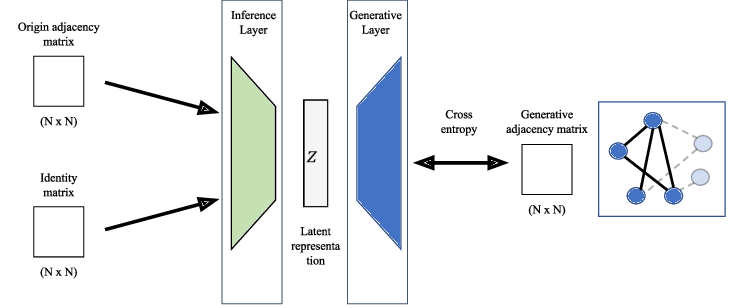

Encoder(Inference): Two layer Graph convolutional layer

Decoder(Generative): Pair-wise inner product of node imbeddings

[BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html): This loss combines a Sigmoid layer and the Binary Cross Entropy.

In [6]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim = -1)

    def decode_all(self, z):
        prob_adj = z @ z.t()

        prob_adj = prob_adj.sigmoid()

        # Return the indices only for very certain edges
        return (prob_adj > 0.99).nonzero(as_tuple = False).t()

In [7]:
model = AutoEncoder(
    citeseer_dataset.num_features,
    hidden_channels = 128,
    out_channels = 64
).to(device)

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

criterion = torch.nn.BCEWithLogitsLoss()

In [8]:
z = model.encode(train_data.x, train_data.edge_index)

z

tensor([[-1.3509e-04,  2.0229e-04,  2.6150e-03,  ..., -5.1374e-03,
          1.9988e-03,  1.3960e-03],
        [-1.5660e-03, -2.2224e-04,  9.4780e-04,  ..., -1.4976e-03,
         -1.3323e-04,  4.9315e-04],
        [-4.4483e-03, -3.4766e-03,  9.6184e-04,  ..., -3.7361e-03,
          2.8816e-03, -2.2147e-03],
        ...,
        [-3.6106e-05, -7.9386e-04,  1.3060e-03,  ..., -3.2557e-03,
          1.1136e-03, -8.1360e-06],
        [-3.7820e-03, -4.8883e-03,  4.4412e-03,  ..., -2.0464e-03,
         -1.4781e-03, -6.6101e-03],
        [-3.7044e-03, -2.0528e-03,  1.3357e-03,  ..., -5.0748e-04,
          1.8151e-03, -2.4696e-03]], device='cuda:0', grad_fn=<AddBackward0>)

z shape (num_nodes, hidden_dim)

In [9]:
z.shape

torch.Size([3327, 64])

#### Model Training
Training with new negative samples for each training epoch

Validation/Test evaluation with roc_auc_score (Area Under the Receiver Operating Characteristic Curve)

In [10]:
def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    # train_data.edge_label_index shape: (2, num_train_edges)
    # neg_edge_index shape: (2, num_train_edges)

    # Perform a new round of negative sampling for every training epoch
    neg_edge_index = negative_sampling(
        edge_index = train_data.edge_index, num_nodes = train_data.num_nodes,
        num_neg_samples = train_data.edge_label_index.size(1))

    # edge_label_index shape: (2, num_train_edges * 2)
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim = -1,
    )

    # edge_label shape: (num_train_edges * 2)
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim = 0)

    # out shape: (num_train_edges * 2)
    out = model.decode(z, edge_label_index).view(-1)

    loss = criterion(out, edge_label)
    loss.backward()

    optimizer.step()

    return loss

In [11]:
@torch.no_grad()
def test(data):
    model.eval()

    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [12]:
best_val_auc = final_test_auc = 0

for epoch in range(100):
    loss = train()

    val_auc = test(val_data)
    test_auc = test(test_data)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, '
              f'Test AUC: {test_auc:.4f}')

print(f'Final Test AUC: {final_test_auc:.4f}')

Epoch: 010, Loss: 0.5733, Val AUC: 0.7839, Test AUC: 0.8065
Epoch: 020, Loss: 0.4975, Val AUC: 0.8697, Test AUC: 0.8731
Epoch: 030, Loss: 0.4695, Val AUC: 0.8907, Test AUC: 0.8891
Epoch: 040, Loss: 0.4601, Val AUC: 0.9058, Test AUC: 0.9010
Epoch: 050, Loss: 0.4523, Val AUC: 0.9017, Test AUC: 0.9023
Epoch: 060, Loss: 0.4401, Val AUC: 0.8986, Test AUC: 0.9017
Epoch: 070, Loss: 0.4357, Val AUC: 0.8939, Test AUC: 0.8974
Epoch: 080, Loss: 0.4287, Val AUC: 0.8916, Test AUC: 0.8989
Epoch: 090, Loss: 0.4250, Val AUC: 0.8870, Test AUC: 0.8988
Epoch: 100, Loss: 0.4315, Val AUC: 0.8845, Test AUC: 0.8952
Final Test AUC: 0.9052


In [13]:
z = model.encode(test_data.x, test_data.edge_index)

z

tensor([[ 0.0238,  0.0223,  0.0475,  ..., -0.0294, -0.0487,  0.0415],
        [-0.2342, -0.1249,  0.0345,  ...,  0.3642, -0.0795,  0.2057],
        [ 0.0638,  0.0139, -0.0924,  ..., -0.0878,  0.1178, -0.1305],
        ...,
        [-0.0916,  0.0673, -0.1083,  ..., -0.1135, -0.0759,  0.1766],
        [ 0.0221,  0.0704, -0.0505,  ...,  0.1714, -0.1012, -0.0230],
        [-0.0558,  0.0510, -0.1723,  ...,  0.3233,  0.2531, -0.1078]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [14]:
z.shape

torch.Size([3327, 64])

In [15]:
final_edge_index = model.decode_all(z)

final_edge_index.shape

torch.Size([2, 7833])

In [16]:
self_loops = final_edge_index[0] == final_edge_index[1]

filtered_edges = final_edge_index[:, ~self_loops]

filtered_edges.shape

torch.Size([2, 7698])

In [17]:
test_data.edge_index.shape

torch.Size([2, 7284])